# Step 1: Data Process


## Import dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# here you will be given a URL and get a code to paste into a box below:

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import random
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import gensim
import csv
import os
import pylab as plt
import math
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


In [0]:
my_dir = "drive/My Drive/Colab Notebooks/"
os.chdir(my_dir)

In [4]:
!ls

 backup					   keras_baseline_4.ipynb
'Copy of keras_baseline_3.ipynb'	   keras_hierarchical_3.ipynb
'Copy of keras_hierarchical_3 (1).ipynb'   keras_hierarchical.ipynb
'Copy of keras_hierarchical_3.ipynb'	   processed_data
 data					   processed_data2
 keras_baseline_1.ipynb			   __pycache__
 keras_baseline_2.ipynb			   sessions


## Load in Data

In [5]:
# Process training data
filename = 'data/train.csv'

# # X: (REVIEW/TEXT), 
# # Y: (REVIEW/APPEARANCE, REVIEW/AROMA, REVIEW/PALATE, REVIEW/TASTE, REVIEW/OVERALL)
x_index = 11
y_index = [6, 7, 9, 10, 8] # reorder index to put overall as the last element
X = []
Y = []

with open(filename) as train:
    csv_reader = csv.reader(train, delimiter=',')
    i = -1
    for row in csv_reader:
      if i == -1:
        i += 1
        continue
      X.append(row[x_index])
      Y.append([row[j] for j in y_index])
      i += 1

print('data loading complete')

data loading complete


In [0]:
# Remove invalid inputs
X_valid = []
Y_valid = []
for i in range(len(X)):
  temp = list(map(float, Y[i]))
  if len(X[i]) != 0 and (0.5 not in temp) and (0.0 not in temp):
    X_valid.append(X[i].lower())
    Y_valid.append(temp)

assert len(X_valid) == len(Y_valid)

In [0]:
# Tokenize and make vocab
X_tokenized = list(map(lambda ele: word_tokenize(ele), X_valid))

In [8]:
print(len(X_tokenized))
print(len(Y_valid))

37489
37489


In [0]:
# Build vocab
vocabulary = set()
for parag in X_tokenized:
  vocabulary.update(set(parag))
vocabulary_dict = {word: (i+1) for i, word in enumerate(vocabulary)}

In [10]:
print(len(vocabulary))
print(len(vocabulary_dict))

61313
61313


In [0]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(X_tokenized, Y_valid, test_size=0.2)

In [12]:
!nvidia-smi

Mon Jan 13 06:40:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Customized Dataset

In [0]:
class MyDataset(keras.utils.Sequence):
  'Characterizes a dataset for PyTorch'
  def __init__(self, documents, scores, word_to_idx, batch_size, hop_size=6):
        'Initialization'
        self.score_to_class_map = {
            1.0: 0,
            1.5: 1,
            2.0: 2,
            2.5: 3,
            3.0: 4,
            3.5: 5,
            4.0: 6,
            4.5: 7,
            5.0: 8
        }

        self.hop_size = hop_size
        self.word_to_idx = word_to_idx
        self.documents = documents
        self.batch_size = batch_size
        
        self.shuffle = True
        self.scores = None
        self.max_length = None
        self._initialize_process(documents, scores)

        # self.w2v = gensim.models.Word2Vec.load(root_dir + './w2v_model_128')
        self.sentence_dimension = int(self.max_length / self.hop_size) 
        self.on_epoch_end()

  def _initialize_process(self, documents, scores):
    assert len(scores) == len(documents)
    
    Y_array = np.asarray(scores, dtype=float)
    Y_mapped = self._prepare_score(Y_array)
    self.scores = Y_mapped

    max_parag_len = len(max(documents, key = lambda sentences : len(sentences)))
    self.max_length = math.ceil(max_parag_len / self.hop_size) * self.hop_size

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.documents))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __len__(self):
        'Denotes the total number of samples'
        return int(len(self.scores) / self.batch_size)

  def __getitem__(self, input_index):
        'Generates one sample of data'
        # Select sample
        X = np.zeros((self.batch_size, self.max_length))
        Y = np.zeros((self.batch_size, 9))

        indexes = self.indexes[input_index*self.batch_size : (input_index+1)*self.batch_size]
        for i in range(self.batch_size):
          index = indexes[i]
          doc = self.documents[index]   
          doc_in_idx = self._prepare_text(doc)    # max_len
          X[i] = doc_in_idx
          Y[i, int(self.scores[index][4])] = 1.0    # TODO: ASPECT CHANGE!!
          # classed_score = self._prepare_score(score)
        return X, Y

  def _prepare_score(self, scores):
      temp = np.zeros((scores.shape[0], scores.shape[1]))
      for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
          temp[i][j] = self.score_to_class_map[scores[i][j]]
      # print(temp)
      return temp

  def _prepare_text(self, parag):
    # parag_idx = []
    # for i, w in enumerate(parag):
    #   parag_idx.append(self.word_to_idx[w])
    X_idx = np.zeros(self.max_length)
    for i, w in enumerate(parag):
      # Pad at the head
      X_idx[self.max_length-len(parag)+i] = self.word_to_idx[w] 

    # X_sentenced = X_embeded.reshape((self.sentence_dimension, self.hop_size, self.embed_size))
    return X_idx


In [0]:
num_classes = 9
batch_size = 64

In [15]:
train_generator = MyDataset(train_X, train_Y, vocabulary_dict, batch_size)
test_x, test_y = train_generator.__getitem__(1)
print(test_x.shape, test_y.shape)

(64, 990) (64, 9)


In [0]:
# val_generator = MyDataset(train_X, train_Y, vocabulary_dict, batch_size)

In [0]:
test_generator = MyDataset(test_X, test_Y, vocabulary_dict, batch_size)

# Step 2: Model Construction

In [0]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Activation, Masking
from keras.layers import Add, Conv2D, MaxPooling1D, GlobalAveragePooling1D

In [0]:
lstm_hidden_size = 512

In [20]:
# LSTM Model
doc = Input(shape=(None,), name="input_doc")

embed_doc = Embedding(len(vocabulary)+1, 300, mask_zero=True, input_length=None)(doc)
masked_embed_doc = Masking(mask_value=0)(embed_doc)
hidden_seq = LSTM(lstm_hidden_size, dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False)(masked_embed_doc)
dense = Dense(256, activation="relu")(hidden_seq)
scores = Dense(num_classes, activation="softmax")(dense)
model = Model(inputs=doc, outputs=scores)

print(model.summary())




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_doc (InputLayer)       (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 300)         18394200  
_________________________________________________________________
masking_1 (Masking)          (None, None, 300)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               1665024   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 2313      
Total params: 20,192,865
Tra

In [0]:
# # CNN Model
# doc = Input(shape=(None,), name="input_doc")

# embed_doc = Embedding(len(vocabulary)+1, 300, mask_zero=False, input_length=None)(doc)

# conv1 = Conv1D(512, 5, strides=1, activation='relu')(embed_doc)
# conv2 = Conv1D(512, 5, strides=1, activation='relu')(conv1)
# max_pool1 = MaxPooling1D()(conv2)
# conv3 = Conv1D(512, 5, strides=1, activation='relu')(max_pool1)
# conv4 = Conv1D(512, 5, strides=1, activation='relu')(conv3)
# global_pool = GlobalAveragePooling1D()(conv4)

# dense = Dense(256, activation="relu")(global_pool)
# scores = Dense(num_classes, activation="softmax")(dense)

# model = Model(inputs=doc, outputs=scores)

# print(model.summary())

In [0]:
path = "./sessions/baseline_aspect4"    # TODO!!
checkpoints_path = os.path.join(path, 'checkpoints')
history_filename = 'history_' + path[path.rindex('/') + 1:] + '.csv'
early_stopping_patience = 10

if not os.path.exists("./sessions"):
    os.mkdir("./sessions")

if not os.path.exists(path):
    os.mkdir(path)

if not os.path.exists(checkpoints_path):
    os.mkdir(checkpoints_path)

In [0]:
# model.load_weights(os.path.join(checkpoints_path, "checkpoint.00009-1.413.hdf5"))

# Step 3: Review Embedding -> Aspect-level Sentiment Score

## Train

In [0]:
class ConfusionMatrixCallback(keras.callbacks.Callback):
  def _plot_confusion_matrix_helper(self, indices, y_expected):
    labels = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    cm = confusion_matrix(y_expected, indices, labels)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

  def _plot_confusion_matrix(self, y_output, y_expected):
    output_idx = np.argmax(y_output, axis=-1)
    # print(output_idx)
    expected_idx = np.argmax(y_expected, axis=-1)
    assert output_idx.shape == expected_idx.shape  # batch * 5
    self._plot_confusion_matrix_helper(output_idx, expected_idx)

  def on_epoch_end(self, epoch, logs=None):
    x_train, y_train = test_generator.__getitem__(random.randint(0, test_generator.__len__()))
    y_predicted = model.predict(x_train)

    self._plot_confusion_matrix(y_predicted, y_train)

In [0]:
def get_callbacks():
    return [
        keras.callbacks.ReduceLROnPlateau(patience=early_stopping_patience / 2,
                                              cooldown=early_stopping_patience / 4,
                                              verbose=1),
        keras.callbacks.EarlyStopping(patience=early_stopping_patience, verbose=1,
                                          monitor='val_loss'),
        keras.callbacks.ModelCheckpoint(os.path.join(checkpoints_path, 'checkpoint.{epoch:05d}-{val_loss:.3f}.hdf5')),
        keras.callbacks.CSVLogger(os.path.join(path, history_filename), append=True),
        ConfusionMatrixCallback()
    ]

In [0]:
def custom_loss(y_true, y_pred):
  return keras.losses.categorical_crossentropy(y_true, y_pred)

In [0]:
def calc_acc(y_expected, y_pred):
  return keras.metrics.categorical_accuracy(y_expected, y_pred)

In [28]:
from keras.optimizers import Adam
model.compile(optimizer=Adam(lr=0.00001), loss=custom_loss, metrics=[calc_acc])




Epoch 10/100





100/100 [==============================] - 219s 2s/step - loss: 2.1868 - calc_acc: 0.3017 - val_loss: 2.1700 - val_calc_acc: 0.3766
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0 10  1  0]
 [ 0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0 16  1  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  4  0  0]]


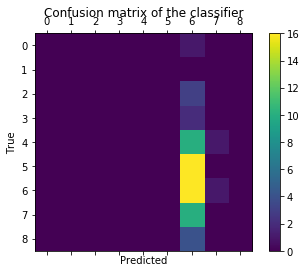

Epoch 11/100
100/100 [==============================] - 210s 2s/step - loss: 2.0041 - calc_acc: 0.3744 - val_loss: 1.7167 - val_calc_acc: 0.3781
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0 18  0  0]
 [ 0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0  5  0  0]]


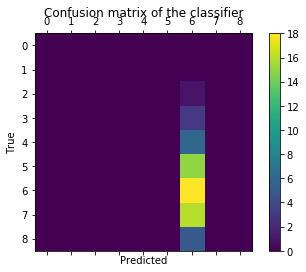

Epoch 12/100
100/100 [==============================] - 209s 2s/step - loss: 1.6920 - calc_acc: 0.3714 - val_loss: 1.7200 - val_calc_acc: 0.3578
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 27  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0  5  0  0]]


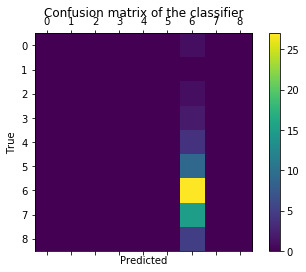

Epoch 13/100
100/100 [==============================] - 209s 2s/step - loss: 1.6734 - calc_acc: 0.3659 - val_loss: 1.6878 - val_calc_acc: 0.3609
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  8  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 26  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


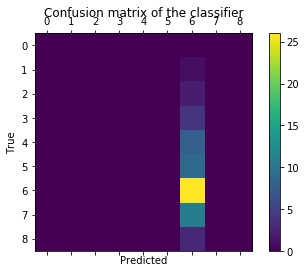

Epoch 14/100
100/100 [==============================] - 210s 2s/step - loss: 1.6612 - calc_acc: 0.3700 - val_loss: 1.7057 - val_calc_acc: 0.3453
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  7  0  0]]


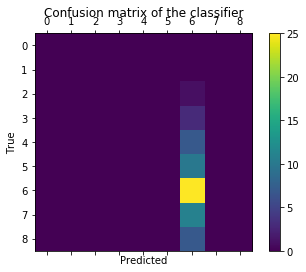

Epoch 15/100
100/100 [==============================] - 209s 2s/step - loss: 1.6698 - calc_acc: 0.3725 - val_loss: 1.6622 - val_calc_acc: 0.4031
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  5  0  0]]


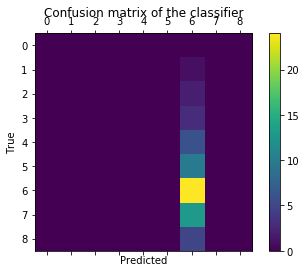

Epoch 16/100
100/100 [==============================] - 209s 2s/step - loss: 1.6505 - calc_acc: 0.3759 - val_loss: 1.6907 - val_calc_acc: 0.3625
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0 35  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


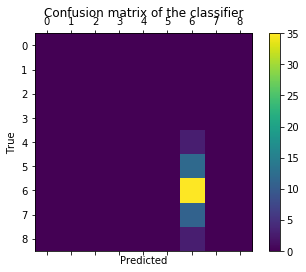

Epoch 17/100
100/100 [==============================] - 209s 2s/step - loss: 1.6686 - calc_acc: 0.3638 - val_loss: 1.6182 - val_calc_acc: 0.4016
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  1  0  0]]


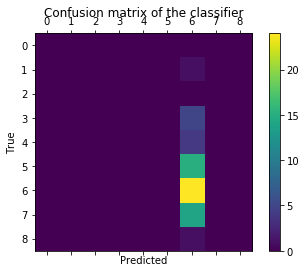

Epoch 18/100
100/100 [==============================] - 207s 2s/step - loss: 1.6712 - calc_acc: 0.3630 - val_loss: 1.6540 - val_calc_acc: 0.3844
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 23  0  0]
 [ 0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0  4  0  0]]


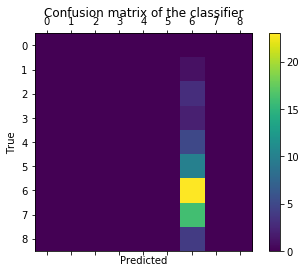

Epoch 19/100
100/100 [==============================] - 208s 2s/step - loss: 1.6573 - calc_acc: 0.3727 - val_loss: 1.7036 - val_calc_acc: 0.3359
[[ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


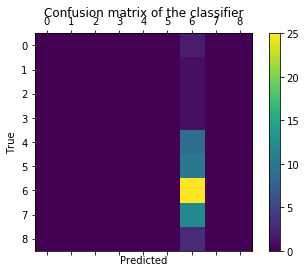

Epoch 20/100
100/100 [==============================] - 210s 2s/step - loss: 1.6681 - calc_acc: 0.3648 - val_loss: 1.6292 - val_calc_acc: 0.3812
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0 19  0  0]
 [ 0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  1  0  0]]


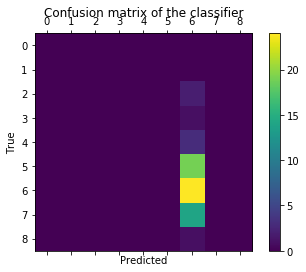

Epoch 21/100
100/100 [==============================] - 206s 2s/step - loss: 1.6569 - calc_acc: 0.3692 - val_loss: 1.6373 - val_calc_acc: 0.3875
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0 19  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  4  0  0]]


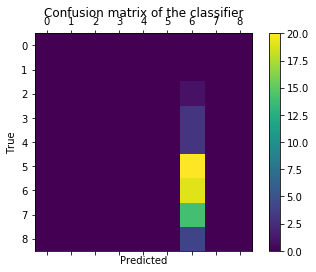

Epoch 22/100
100/100 [==============================] - 208s 2s/step - loss: 1.6324 - calc_acc: 0.3795 - val_loss: 1.6597 - val_calc_acc: 0.3688

Epoch 00022: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


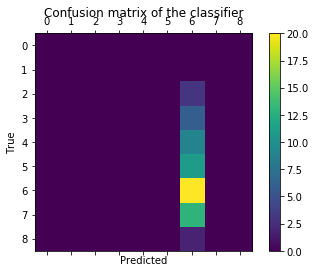

Epoch 23/100
100/100 [==============================] - 209s 2s/step - loss: 1.6603 - calc_acc: 0.3622 - val_loss: 1.6717 - val_calc_acc: 0.3625
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0 23  0  0]
 [ 0  0  0  0  0  0  4  0  0]]


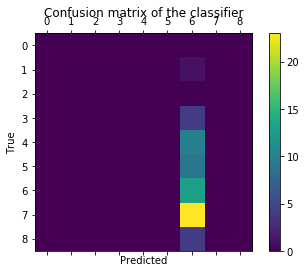

Epoch 24/100
100/100 [==============================] - 206s 2s/step - loss: 1.6535 - calc_acc: 0.3655 - val_loss: 1.6267 - val_calc_acc: 0.3891
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0  0  0  0]]


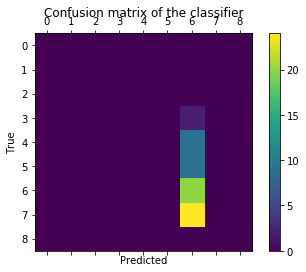

Epoch 25/100
100/100 [==============================] - 208s 2s/step - loss: 1.6535 - calc_acc: 0.3734 - val_loss: 1.6691 - val_calc_acc: 0.3516
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0 26  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  1  0  0]]


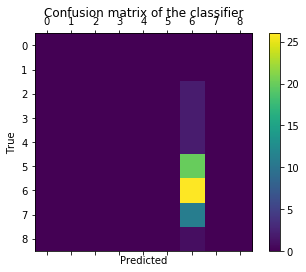

Epoch 26/100
100/100 [==============================] - 207s 2s/step - loss: 1.6547 - calc_acc: 0.3734 - val_loss: 1.6654 - val_calc_acc: 0.3766
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  4  0  0]]


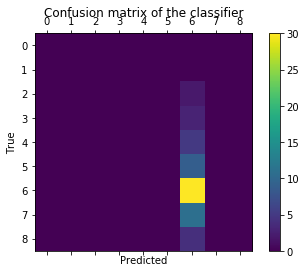

Epoch 27/100
100/100 [==============================] - 206s 2s/step - loss: 1.6400 - calc_acc: 0.3714 - val_loss: 1.6822 - val_calc_acc: 0.3594
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 21  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  7  0  0]]


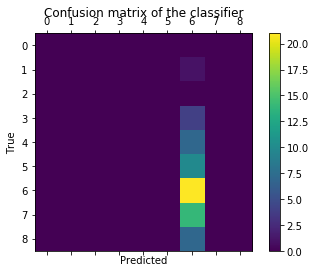

Epoch 28/100
100/100 [==============================] - 206s 2s/step - loss: 1.6542 - calc_acc: 0.3600 - val_loss: 1.6806 - val_calc_acc: 0.3609
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


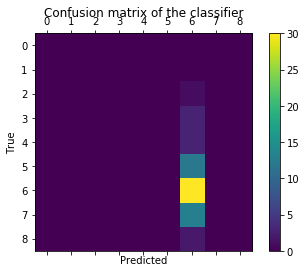

Epoch 29/100
100/100 [==============================] - 207s 2s/step - loss: 1.6382 - calc_acc: 0.3730 - val_loss: 1.5699 - val_calc_acc: 0.4234
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0 29  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


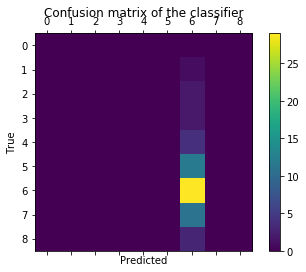

Epoch 30/100
100/100 [==============================] - 205s 2s/step - loss: 1.6466 - calc_acc: 0.3758 - val_loss: 1.7153 - val_calc_acc: 0.3344
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0  6  0  0]]


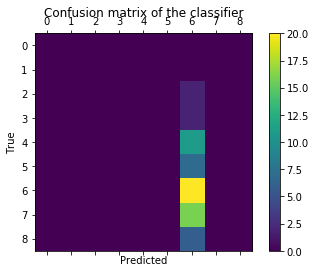

Epoch 31/100
100/100 [==============================] - 205s 2s/step - loss: 1.6498 - calc_acc: 0.3669 - val_loss: 1.6803 - val_calc_acc: 0.3578
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0 23  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


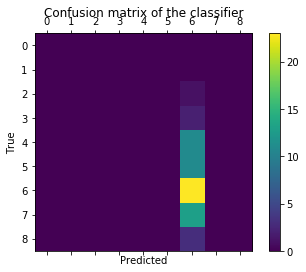

Epoch 32/100
100/100 [==============================] - 205s 2s/step - loss: 1.6473 - calc_acc: 0.3659 - val_loss: 1.6493 - val_calc_acc: 0.3812
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 21  0  0]
 [ 0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0  5  0  0]]


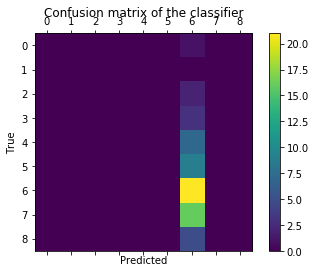

Epoch 33/100
100/100 [==============================] - 204s 2s/step - loss: 1.6496 - calc_acc: 0.3670 - val_loss: 1.6293 - val_calc_acc: 0.3766
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  8  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0 23  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


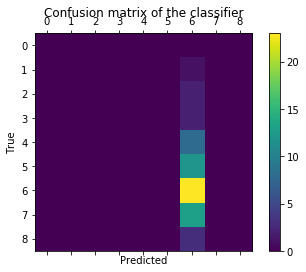

Epoch 34/100
100/100 [==============================] - 204s 2s/step - loss: 1.6409 - calc_acc: 0.3684 - val_loss: 1.6697 - val_calc_acc: 0.3625

Epoch 00034: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0 19  0  0]
 [ 0  0  0  0  0  0 21  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


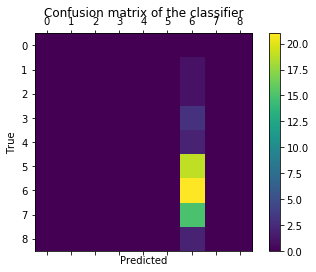

Epoch 35/100
100/100 [==============================] - 204s 2s/step - loss: 1.6433 - calc_acc: 0.3723 - val_loss: 1.6588 - val_calc_acc: 0.3625
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0 17  0  0]
 [ 0  0  0  0  0  0 18  0  0]
 [ 0  0  0  0  0  0  7  0  0]]


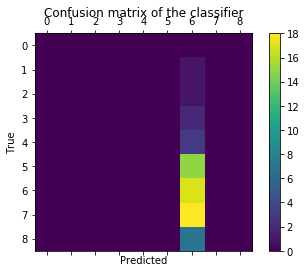

Epoch 36/100
100/100 [==============================] - 203s 2s/step - loss: 1.6454 - calc_acc: 0.3730 - val_loss: 1.6922 - val_calc_acc: 0.3625
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 21  0  0]
 [ 0  0  0  0  0  0  1  0  0]]


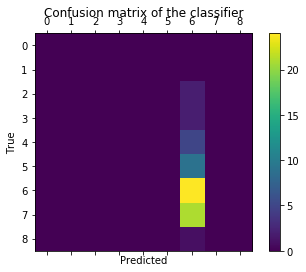

Epoch 37/100
100/100 [==============================] - 203s 2s/step - loss: 1.6509 - calc_acc: 0.3655 - val_loss: 1.5964 - val_calc_acc: 0.3875
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  4  0  0]]


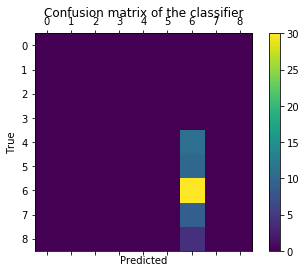

Epoch 38/100
100/100 [==============================] - 208s 2s/step - loss: 1.6630 - calc_acc: 0.3667 - val_loss: 1.6937 - val_calc_acc: 0.3344
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 26  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


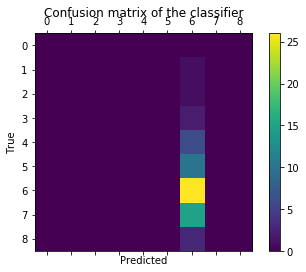

Epoch 39/100
100/100 [==============================] - 207s 2s/step - loss: 1.6351 - calc_acc: 0.3663 - val_loss: 1.6587 - val_calc_acc: 0.3719
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  5  0  0]]


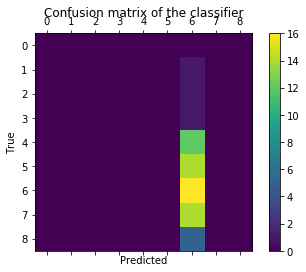

Epoch 40/100
100/100 [==============================] - 208s 2s/step - loss: 1.6463 - calc_acc: 0.3630 - val_loss: 1.6325 - val_calc_acc: 0.3688
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 26  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0  1  0  0]]


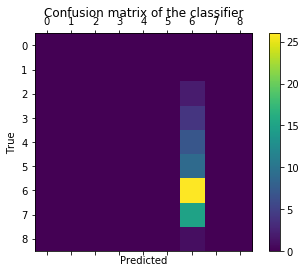

Epoch 41/100
100/100 [==============================] - 210s 2s/step - loss: 1.6351 - calc_acc: 0.3805 - val_loss: 1.6892 - val_calc_acc: 0.3688

Epoch 00041: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  4  0  0]]


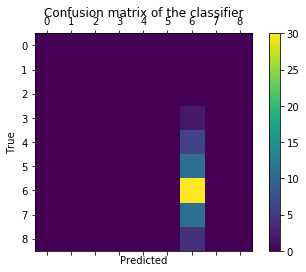

Epoch 42/100
100/100 [==============================] - 210s 2s/step - loss: 1.6473 - calc_acc: 0.3666 - val_loss: 1.5744 - val_calc_acc: 0.4313
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 27  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  6  0  0]]


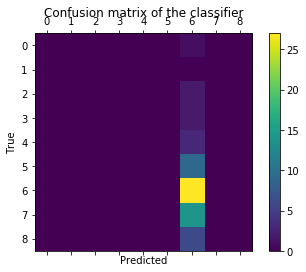

Epoch 43/100
100/100 [==============================] - 204s 2s/step - loss: 1.6393 - calc_acc: 0.3752 - val_loss: 1.6491 - val_calc_acc: 0.3828
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


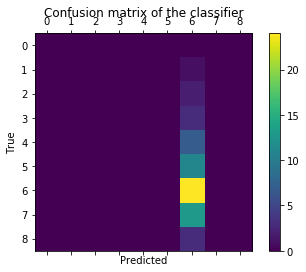

Epoch 44/100
100/100 [==============================] - 204s 2s/step - loss: 1.6490 - calc_acc: 0.3697 - val_loss: 1.6605 - val_calc_acc: 0.3578
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0  1  0  0]]


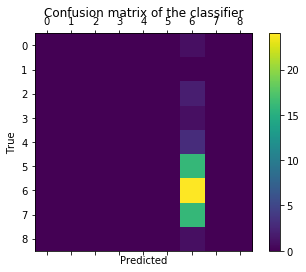

Epoch 45/100
100/100 [==============================] - 208s 2s/step - loss: 1.6439 - calc_acc: 0.3716 - val_loss: 1.6294 - val_calc_acc: 0.3563
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  8  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0 22  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


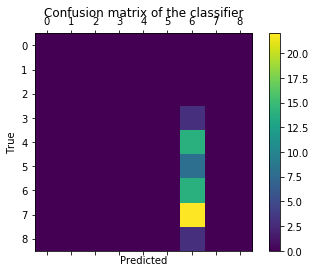

Epoch 46/100
100/100 [==============================] - 207s 2s/step - loss: 1.6414 - calc_acc: 0.3633 - val_loss: 1.6629 - val_calc_acc: 0.3625
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  8  0  0]]


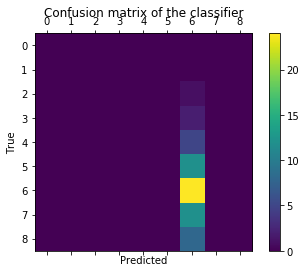

Epoch 47/100
100/100 [==============================] - 209s 2s/step - loss: 1.6355 - calc_acc: 0.3756 - val_loss: 1.6104 - val_calc_acc: 0.3984
[[ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0 18  0  0]
 [ 0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


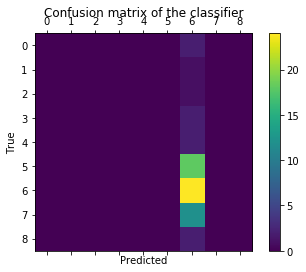

Epoch 48/100
100/100 [==============================] - 208s 2s/step - loss: 1.6446 - calc_acc: 0.3619 - val_loss: 1.7128 - val_calc_acc: 0.3672

Epoch 00048: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0 22  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  5  0  0]]


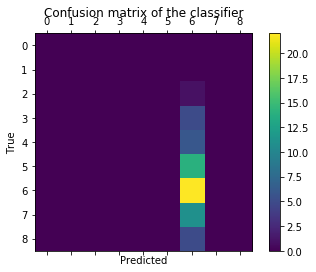

Epoch 49/100
100/100 [==============================] - 206s 2s/step - loss: 1.6443 - calc_acc: 0.3684 - val_loss: 1.6494 - val_calc_acc: 0.3812
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0 18  0  0]
 [ 0  0  0  0  0  0 17  0  0]
 [ 0  0  0  0  0  0  6  0  0]]


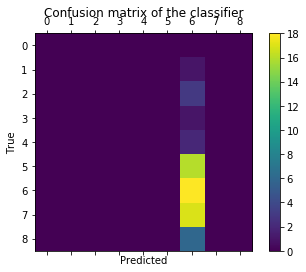

Epoch 50/100
100/100 [==============================] - 207s 2s/step - loss: 1.6526 - calc_acc: 0.3656 - val_loss: 1.6698 - val_calc_acc: 0.3641
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 18  0  0]
 [ 0  0  0  0  0  0  6  0  0]]


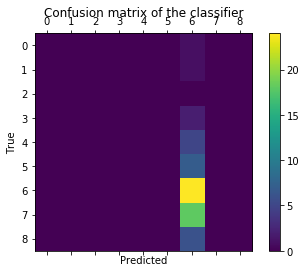

Epoch 51/100
100/100 [==============================] - 208s 2s/step - loss: 1.6371 - calc_acc: 0.3781 - val_loss: 1.6745 - val_calc_acc: 0.3500
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0 18  0  0]
 [ 0  0  0  0  0  0 22  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


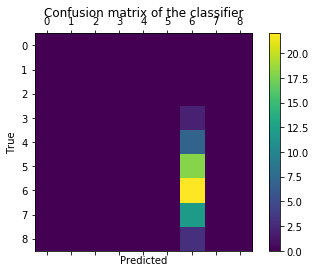

Epoch 52/100
100/100 [==============================] - 206s 2s/step - loss: 1.6577 - calc_acc: 0.3638 - val_loss: 1.6098 - val_calc_acc: 0.3797
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0 22  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  5  0  0]]


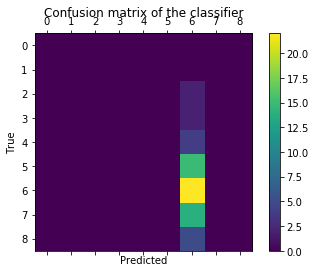

Epoch 53/100
100/100 [==============================] - 205s 2s/step - loss: 1.6359 - calc_acc: 0.3733 - val_loss: 1.6360 - val_calc_acc: 0.4000
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 27  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  4  0  0]]


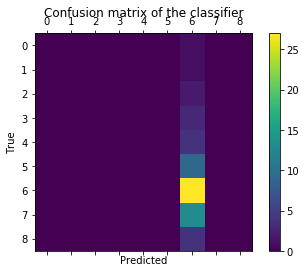

Epoch 54/100
 89/100 [=========================>....] - ETA: 22s - loss: 1.6270 - calc_acc: 0.3815

In [0]:
model.fit_generator(train_generator, 
          epochs=100, 
          verbose=1, 
          callbacks=get_callbacks(), 
          validation_data=test_generator, 
          shuffle=True, 
          initial_epoch=9, 
          steps_per_epoch=100, 
          validation_steps=10)

## Test

In [0]:
path = "./sessions/baseline_aspect4"  #TODO!!
checkpoints_path = os.path.join(path, 'checkpoints')
history_filename = 'history_' + path[path.rindex('/') + 1:] + '.csv'
early_stopping_patience = 10

if not os.path.exists("./sessions"):
    os.mkdir("./sessions")

if not os.path.exists(path):
    os.mkdir(path)

if not os.path.exists(checkpoints_path):
    os.mkdir(checkpoints_path)

In [0]:
val_X = val_generator.data_generation(val_generator.list_IDs)

AttributeError: ignored

In [0]:
val_Pred = model.predict(val_X[0], batch_size=64)

In [0]:
pred_dict = []
for j, ID in enumerate(val_generator.list_IDs):
  pred_dict.append({"question_id": ID, "answer": answers_1000[np.argmax(val_Pred[j, :])][0]})
print(val_Pred.shape)